# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [210]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [211]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [212]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-04 09:00:00+09:00,52294.308594,52409.640625,52083.480469,52273.828125,0,0.0,0.0
2025-11-04 09:15:00+09:00,52278.238281,52291.878906,52020.679688,52153.058594,0,0.0,0.0
2025-11-04 09:30:00+09:00,52130.921875,52305.609375,52130.921875,52268.878906,0,0.0,0.0
2025-11-04 09:45:00+09:00,52265.609375,52431.921875,52239.218750,52429.410156,0,0.0,0.0
2025-11-04 10:00:00+09:00,52423.789062,52499.441406,52369.359375,52468.050781,0,0.0,0.0
2025-11-04 10:15:00+09:00,52462.179688,52636.871094,52440.371094,52554.761719,0,0.0,0.0
2025-11-04 10:30:00+09:00,52558.839844,52577.800781,52453.601562,52472.660156,0,0.0,0.0
2025-11-04 10:45:00+09:00,52477.328125,52558.121094,52418.019531,52524.109375,0,0.0,0.0
2025-11-04 11:00:00+09:00,52533.371094,52533.371094,52424.628906,52437.289062,0,0.0,0.0


## 前日終値の取得

In [213]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-28 00:00:00+09:00    50219.179688
2025-10-29 00:00:00+09:00    51307.648438
2025-10-30 00:00:00+09:00    51325.609375
2025-10-31 00:00:00+09:00    52411.339844
2025-11-04 00:00:00+09:00    52000.289062
Name: Close, dtype: float64


Date
2025-10-31 00:00:00+09:00    52411.339844
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [214]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-117.03


## ローソク足チャート（小さいサイズ）

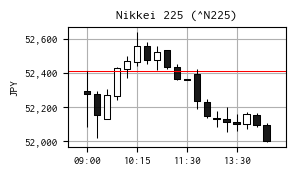

In [215]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [216]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [217]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-03 09:00:00+09:00,154.199005,154.209000,154.158005,154.190002,0,0.0,0.0
2025-11-03 09:15:00+09:00,154.186996,154.216003,154.113998,154.149994,0,0.0,0.0
2025-11-03 09:30:00+09:00,154.149994,154.201996,154.139008,154.153000,0,0.0,0.0
2025-11-03 09:45:00+09:00,154.151993,154.197998,154.143005,154.169998,0,0.0,0.0
2025-11-03 10:00:00+09:00,154.169998,154.188004,154.119995,154.128006,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-04 13:30:00+09:00,153.981995,153.998993,153.804993,153.863007,0,0.0,0.0
2025-11-04 13:45:00+09:00,153.860001,154.065002,153.858002,154.056000,0,0.0,0.0
2025-11-04 14:00:00+09:00,154.056000,154.080994,153.901001,153.903000,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [218]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-04 09:00:00+09:00,338.803411,339.550622,337.437502,338.670723
2025-11-04 09:15:00+09:00,338.813445,338.901849,337.144216,338.002159
2025-11-04 09:30:00+09:00,337.847767,338.979874,337.847767,338.741833
2025-11-04 09:45:00+09:00,338.654804,339.732425,338.483806,339.716151
2025-11-04 10:00:00+09:00,339.598307,340.088379,339.245715,339.885032
2025-11-04 10:15:00+09:00,339.651168,340.782157,339.509975,340.250564
2025-11-04 10:30:00+09:00,340.581257,340.704124,339.899313,340.022812
2025-11-04 10:45:00+09:00,340.048656,340.572188,339.664342,340.351795
2025-11-04 11:00:00+09:00,340.460352,340.460352,339.755612,339.837660


### 前日の終値のドル円レートから、前日の終値のドル換算

In [219]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-03 15:15:00+09:00


np.float64(154.2239990234375)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 339.8390663944917


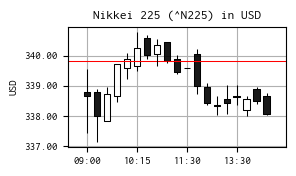

In [220]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()